# What factors affect the periodic variation of the daily Citi-Bike rides?
# --Time series analysis of the Citi-Bike rides in New York City.

## Individual project by Junjie Cai

# Abstract: 
This study explores the periodic variation and the influencing factors of daily Citi-Bike rides and further predicts the number of daily rides with different models. This study comes to conclusions that the time series of daily Citi-Bike rides has strong and stable semi-annual periodic autocorrelation; and the factors most affect the periodic variation of the Citi-Bike rides are temperature, wind speed, and precipitation; and finally choose the multivariate linear regression model with variables of temperature, wind, rainfall, snowfall, holiday and weekday to fit and predict 70% of the daily Citi-Bike rides.


# Introduction:  
Three critical and basic questions of the time series of Citi-Bike rides are the cornerstone. Scientific tools and methods of data science are used to analyze and answer the questions.
* First of all, is there any periodic variation and the overall trend of the Citi-Bike rides? 
The first part of this study analyzes the time series of the Citi-Bike rides to find the period, trend and noise. The hypothesis is that the number of Citi-Bike rides is periodic and has an overall trend. At the same time, the trend variation of time series in different areas of New York is explored.
* Secondly, what factors affect the periodic variation of the Citi-Bike rides? 
In general idea, it is temperature, wind, rainfall, snowfall, events, holiday and weekday that affect the daily Citi-Bike rides. The second part of this study explores how these factors actually affect the Citi-Bike rides. The hypothesis is that the periodic variation of the Citi-Bike rides has a strong correlation with the factors of temperature, wind, rainfall, snowfall, events, holiday and weekday.  
* Thirdly, can we predict the number of the daily Citi-Bike rides?
The third part of this study simulates the daily Citi-Bike rides with multivariate models and predicts the daily number of the Citi-Bike rides with this model in the test samples. The hypothesis is that the periodic variation of the Citi-Bike rides can be explained by these factors, and the number of daily Citi-Bike rides can be explained by these factors.

In [1]:
from __future__ import print_function, division

import os
import zipfile
import urllib

import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from fiona.crs import from_epsg

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.ensemble  import RandomForestClassifier as rfc
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

import pylab as pl
import matplotlib.pylab as plt
from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Download and merge 5 years and 5 months datasets

In [2]:
def getCitiBikeCSVold(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile("data/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + "data"):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile("data/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + "data/")                
            ### unzip the csv 
            os.system("unzip " + "data/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            if '2013' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + "data")
    ### One final check:
    if not os.path.isfile("data/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [3]:
# Revise the function to support the datasets after 201612
def getCitiBikeCSVnew(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile("data/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + "data"):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile("data/"  + "/" + datestring + "-citibike-tripdata.csv.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.csv.zip"):
                    #os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                    
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.csv.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.csv.zip " + "data/" )
            ### unzip the csv 
            os.system("unzip " + "data/"  + "/" + datestring + "-citibike-tripdata.csv.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + "data/" )
    ### One final check:
    if not os.path.isfile("data/"  + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [4]:
monthlist = []
for i in range(2013,2019):
    for j in range(1,13):
        if j >= 10:
            temp = str(i) + str(j) 
        else:
            temp = str(i) + '0' + str(j) 
        monthlist.append(temp)
monthlist = monthlist[6:-1]
print(len(monthlist))
print(monthlist[0], monthlist[64])

65
201307 201811


In [5]:
monthlist[42]

'201701'

In [6]:
df_monthlist = pd.DataFrame(monthlist[:42])
df_monthlist.columns = [['month']]
df_monthlist.month.apply(getCitiBikeCSVold)

file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in 

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
22    None
23    None
24    None
25    None
26    None
27    None
28    None
29    None
30    None
31    None
32    None
33    None
34    None
35    None
36    None
37    None
38    None
39    None
40    None
41    None
Name: month, dtype: object

In [7]:
df_monthlist = pd.DataFrame(monthlist[42:])
df_monthlist.columns = [['month']]
df_monthlist.month.apply(getCitiBikeCSVnew)

file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue


0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
22    None
Name: month, dtype: object

# Merge function

## function

In [8]:
# debug:https://stackoverflow.com/questions/18016037/pandas-parsererror-eof-character-when-reading-multiple-csv-files-to-hdf5
# read_csv (...quoting=3, error_bad_lines=False)

In [9]:
def timetodate19(df):
    return df[:10]

def timetodate17(df):
    return df[:8]

def timetodate18(df):
    return df[:9]

def delquot(df):
    return df[1:-1]

In [10]:
def datamerge(datestring):
    # read in data
    try:
        df_initial = pd.read_csv("data/" + datestring + '-citibike-tripdata.csv', usecols=['starttime', 'start station id'])    
    except:
        try: #Error201610
            df_initial = pd.read_csv("data/" + datestring + '-citibike-tripdata.csv', usecols=['Start Time', 'Start Station ID'])
            df_initial.columns = ['starttime', 'start station id']  
        except: #Error201710, until 2017-10-22(and this date is partly missing, only contains 21 valid days)          
            df_initial = pd.read_csv("data/" + datestring + '-citibike-tripdata.csv', quoting=3, encoding='utf-8')
            df_initial = df_initial[[1,3]]
            df_initial.columns = ['starttime', 'start station id']
            df_initial['starttime'] = df_initial['starttime'].apply(delquot)

    if len(df_initial['starttime'][0])==24:# after 201712
        df_initial['startdate'] = df_initial['starttime'].astype(str).apply(timetodate19)                        
    if len(df_initial['starttime'][0])==19: # before 201409
        df_initial['startdate'] = df_initial['starttime'].astype(str).apply(timetodate19)
    if len(df_initial['starttime'][0])==18:
        df_initial['startdate'] = df_initial['starttime'].astype(str).apply(timetodate18)
    if len(df_initial['starttime'][0])<=17:
        df_initial['startdate'] = df_initial['starttime'].astype(str).apply(timetodate17)
    # the first month data
    df_merge1 = df_initial.copy()
    datestring = df_merge1['startdate'].unique()[0]
    df_merge1 = df_merge1[df_merge1['startdate']==datestring].groupby('start station id').count()['startdate'].reset_index()
    df_merge1.rename(columns={'startdate':datestring}, inplace=True)

    for i in list(df_initial['startdate'].unique())[1:]:
        df_temp = df_initial.copy()
        datestring = i
        df_temp = df_temp[df_temp['startdate']==datestring].groupby('start station id').count()['startdate'].reset_index()
        df_temp.rename(columns={'startdate':datestring}, inplace=True)
        df_merge1 = pd.merge(df_merge1, df_temp, on='start station id')
    print(df_merge1.shape)
    return df_merge1

In [11]:
%%time
if not os.path.isfile("start_timeseries.csv"):
    # group by daily data for every month
    dictdata = {}
    for i in monthlist:
        print(i)
        dictdata[i] = datamerge(i)
    # merge months data
    dfmerge = dictdata['201307']
    for i in monthlist[1:]:
        dfmerge = pd.merge(dfmerge, dictdata[i], on='start station id',how='outer')
        print(i)
        print(dfmerge.shape)
    # output to csv file
    dfmerge.to_csv("start_timeseries.csv")
else:
    print ("file in place, you can continue")  

file in place, you can continue
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 73.4 µs


## Stations coordinates in space

In [12]:
!curl https://raw.githubusercontent.com/JunjieTsai/Datasets/master/station.csv > station.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  101k  100  101k    0     0   629k      0 --:--:-- --:--:-- --:--:--  627k


In [13]:
station = pd.read_csv("station.csv").drop(['Unnamed: 0', 'availableBikes', 'departs', 'totalDocks'],axis=1)
print(station.shape)
station.head(3)

(1634, 4)


,id,lat,lng,stAddress
0,281,40.764397,-73.973715,Grand Army Plaza & Central Park S
1,72,40.767272,-73.993929,W 52 St & 11 Ave
2,79,40.719116,-74.006667,Franklin St & W Broadway


In [14]:
# combine lat and lon to one column
station['lonlat'] = list(zip(station.lng, station.lat))
# Create Point Geometry for based on lonlat column
station['geometry'] = station[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [15]:
station = gpd.GeoDataFrame(station)
station.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet

In [16]:
station.head()

,id,lat,lng,stAddress,lonlat,geometry
0,281,40.764397,-73.973715,Grand Army Plaza & Central Park S,"(-73.97371465, 40.7643971)",POINT (-73.97371465000001 40.7643971)
1,72,40.767272,-73.993929,W 52 St & 11 Ave,"(-73.99392888, 40.76727216)",POINT (-73.99392888 40.76727216)
2,79,40.719116,-74.006667,Franklin St & W Broadway,"(-74.00666661, 40.71911552)",POINT (-74.00666661 40.71911552)
3,82,40.711174,-74.000165,St James Pl & Pearl St,"(-74.00016545, 40.71117416)",POINT (-74.00016545 40.71117416)
4,83,40.683826,-73.976323,Atlantic Ave & Fort Greene Pl,"(-73.97632328, 40.68382604)",POINT (-73.97632328 40.68382604)


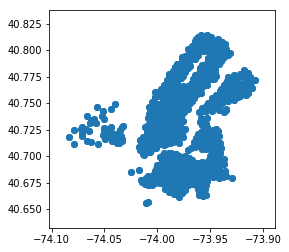

In [17]:
station.plot()

# Part I: Time series analysis

# Plot

In [18]:
stationnumber = pd.read_csv("stationnumber.csv").drop(['Unnamed: 0'], axis=1)

In [19]:
df = pd.read_csv("start_timeseries.csv").drop(['Unnamed: 0'], axis=1)
df.index = df['start station id']
df.drop(['start station id'], axis=1, inplace=True)
print(df.shape)
df.head()

(860, 1962)


,2013-07-01,2013-07-02,2013-07-03,2013-07-04,2013-07-05,2013-07-06,2013-07-07,2013-07-08,2013-07-09,2013-07-10,...,2018-11-21,2018-11-22,2018-11-23,2018-11-24,2018-11-25,2018-11-26,2018-11-27,2018-11-28,2018-11-29,2018-11-30
start station id,,,,,,,,,,,,,,,,,,,,,
72.0,55.0,85.0,88.0,87.0,83.0,85.0,88.0,111.0,125.0,88.0,...,63.0,16.0,29.0,42.0,55.0,76.0,121.0,103.0,104.0,90.0
79.0,88.0,120.0,115.0,128.0,136.0,172.0,145.0,145.0,139.0,146.0,...,54.0,8.0,18.0,28.0,60.0,27.0,60.0,62.0,79.0,65.0
82.0,18.0,28.0,26.0,38.0,31.0,40.0,19.0,30.0,27.0,41.0,...,44.0,18.0,19.0,28.0,27.0,16.0,42.0,30.0,35.0,25.0
83.0,30.0,27.0,44.0,60.0,35.0,41.0,44.0,49.0,51.0,39.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116.0,58.0,80.0,86.0,81.0,67.0,62.0,69.0,98.0,112.0,139.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Time series of the number of station:

Text(0.5,1,'time series of the number of start stations')

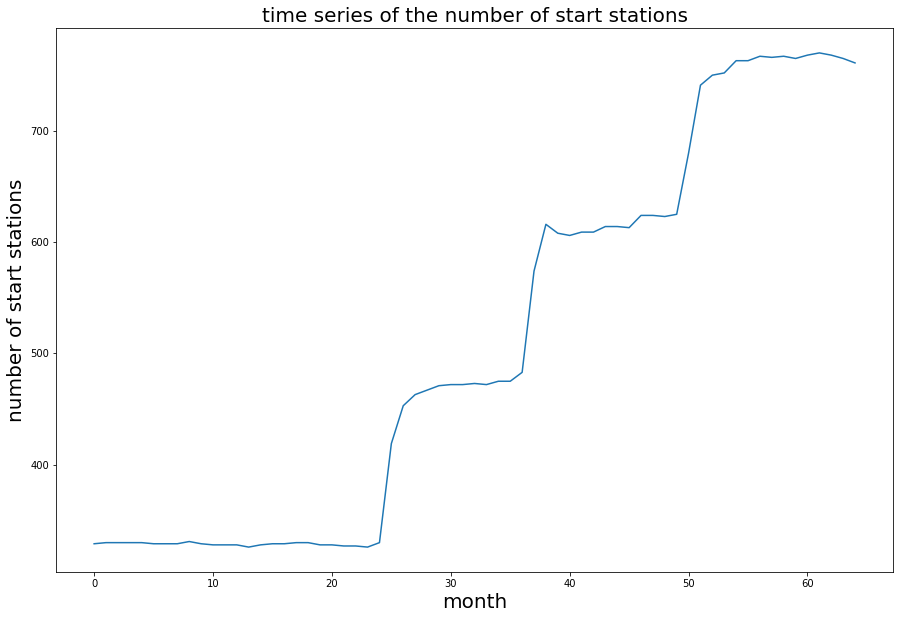

In [20]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.plot(range(65), stationnumber, '-')
ax.set_ylabel('number of start stations', fontsize=20)
ax.set_xlabel('month', fontsize=20)
ax.set_title('time series of the number of start stations', fontsize=20)

### Bike start activity time series for each station:

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


Text(0.5,1,'time series for each station of the number of bike start activities')

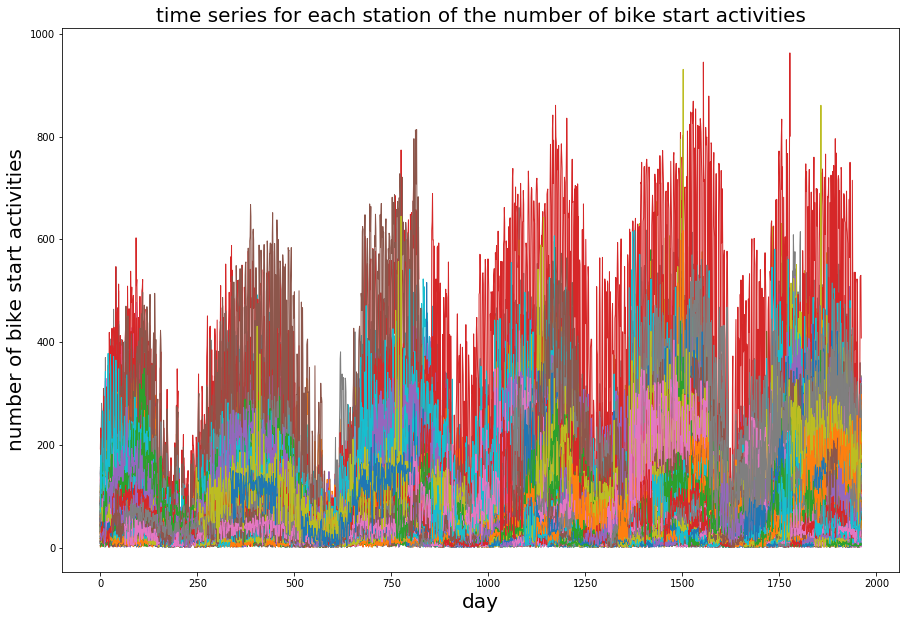

In [21]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i in range(df.shape[0]):
    ax.plot(range(df.shape[1]), df.irow(i), '-', linewidth=1)
ax.set_ylabel('number of bike start activities', fontsize=20)
ax.set_xlabel('day', fontsize=20)
ax.set_title('time series for each station of the number of bike start activities', fontsize=20)

### Average time series:

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


Text(0.5,1,'average time series for each station of the number of bike start activities')

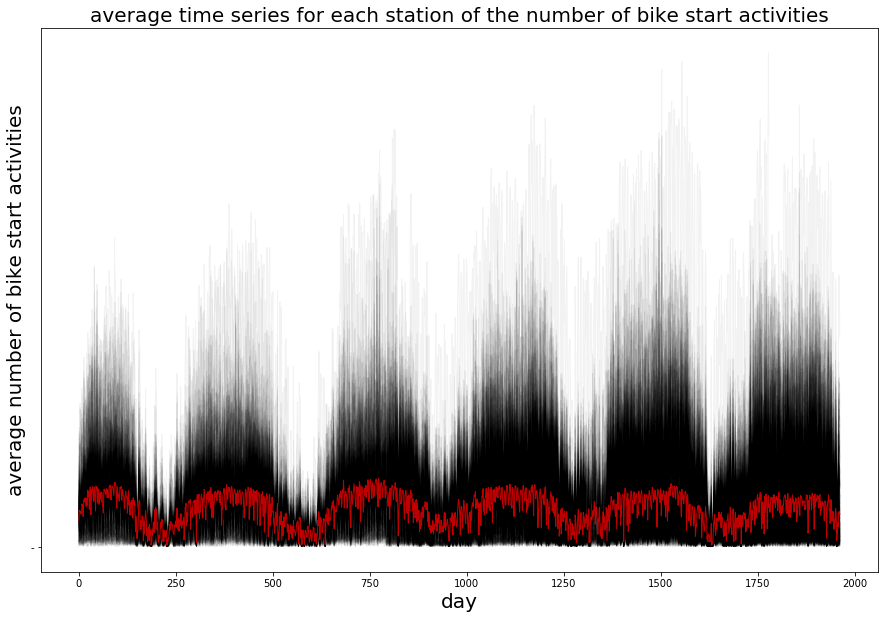

In [22]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i in range(df.shape[0]):
    ax.plot(range(df.shape[1]), df.irow(i), 'black', '-', alpha=0.05, linewidth=1)
ax.plot(range(df.shape[1]), df.mean(axis=0), 'r', '-', alpha=0.75, linewidth=1)
ax.set_ylabel('average number of bike start activities', fontsize=20)
ax.set_xlabel('day', fontsize=20)
ax.set_title('average time series for each station of the number of bike start activities', fontsize=20)

### Smoothed average time series:

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=100).mean()
  if __name__ == '__main__':


Text(0.5,1,'smoothed average time series for each station of the number of bike start activities')

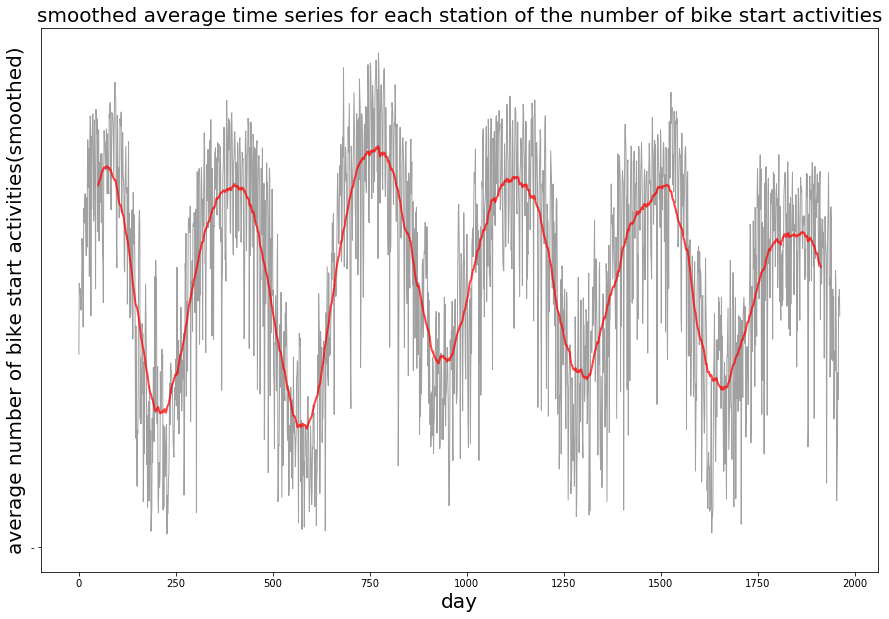

In [23]:
df_rmean = pd.rolling_mean(df.mean(axis=0), 100, center=True)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.plot(range(df.shape[1]), df.mean(axis=0), 'grey', '-', alpha=0.75, linewidth=1)
ax.plot(range(df.shape[1]), df_rmean, 'r', '-', alpha=0.75, linewidth=2)
ax.set_ylabel('average number of bike start activities(smoothed)', fontsize=20)
ax.set_xlabel('day', fontsize=20)
ax.set_title('smoothed average time series for each station of the number of bike start activities', fontsize=20)

# Modeling

## Fill in missing dates

In [24]:
# 4 days missing: 201601: 23, 24, 25, 26
n = np.where(df.columns == '1/1/2016')[0][0]+21+1
left = df[list(range(n))]
right = df[list(range(n,df.shape[1]))]
for i in range(23,27):
    left[str(i)] = NaN
#df = temp.join(df[list(range(936,df.shape[1]))])
df = pd.merge(left,right, left_index=True, right_index=True, how="outer")
df.shape

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(860, 1966)

In [25]:
# 1 day missing: 20170209
n = np.where(df.columns == '2017-02-08')[0][0]+1
left = df[list(range(n))]
right = df[list(range(n,df.shape[1]))]
for i in range(8,9):
    left[str(i)] = NaN
#df = temp.join(df[list(range(936,df.shape[1]))])
df = pd.merge(left,right, left_index=True, right_index=True, how="outer")
df.shape

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(860, 1967)

In [26]:
# 3 days missing: 201703: 14, 15, 16
n = np.where(df.columns == '2017-03-13')[0][0]+1
left = df[list(range(n))]
right = df[list(range(n,df.shape[1]))]
for i in range(14,17):
    left[str(i)] = NaN
#df = temp.join(df[list(range(936,df.shape[1]))])
df = pd.merge(left,right, left_index=True, right_index=True, how="outer")
df.shape

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(860, 1970)

In [27]:
# 9 days missing: 201710: 23 to 31
n = np.where(df.columns == '2017-10-22')[0][0]+1
left = df[list(range(n))]
right = df[list(range(n,df.shape[1]))]
for i in range(23,32):
    left['2017-10-' + str(i)] = NaN
#df = temp.join(df[list(range(936,df.shape[1]))])
df = pd.merge(left,right, left_index=True, right_index=True, how="outer")
df.shape

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(860, 1979)

## Assign exact datetime attribute

In [28]:
date_range = pd.date_range('07/01/2013', '11/30/2018', freq='D' )
print(len(date_range))
date_range

1979


DatetimeIndex(['2013-07-01', '2013-07-02', '2013-07-03', '2013-07-04',
               '2013-07-05', '2013-07-06', '2013-07-07', '2013-07-08',
               '2013-07-09', '2013-07-10',
               ...
               '2018-11-21', '2018-11-22', '2018-11-23', '2018-11-24',
               '2018-11-25', '2018-11-26', '2018-11-27', '2018-11-28',
               '2018-11-29', '2018-11-30'],
              dtype='datetime64[ns]', length=1979, freq='D')

In [29]:
df.columns = date_range.date
df.head()

,2013-07-01,2013-07-02,2013-07-03,2013-07-04,2013-07-05,2013-07-06,2013-07-07,2013-07-08,2013-07-09,2013-07-10,...,2018-11-21,2018-11-22,2018-11-23,2018-11-24,2018-11-25,2018-11-26,2018-11-27,2018-11-28,2018-11-29,2018-11-30
start station id,,,,,,,,,,,,,,,,,,,,,
72.0,55.0,85.0,88.0,87.0,83.0,85.0,88.0,111.0,125.0,88.0,...,63.0,16.0,29.0,42.0,55.0,76.0,121.0,103.0,104.0,90.0
79.0,88.0,120.0,115.0,128.0,136.0,172.0,145.0,145.0,139.0,146.0,...,54.0,8.0,18.0,28.0,60.0,27.0,60.0,62.0,79.0,65.0
82.0,18.0,28.0,26.0,38.0,31.0,40.0,19.0,30.0,27.0,41.0,...,44.0,18.0,19.0,28.0,27.0,16.0,42.0,30.0,35.0,25.0
83.0,30.0,27.0,44.0,60.0,35.0,41.0,44.0,49.0,51.0,39.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116.0,58.0,80.0,86.0,81.0,67.0,62.0,69.0,98.0,112.0,139.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
y_all = pd.DataFrame(df.mean(axis=0)).fillna(value=0)
y_all.columns = ['y']
y_all.index = date_range
print(y_all.shape)
y_all.head()

(1979, 1)


,y
2013-07-01,52.482540
2013-07-02,71.752381
2013-07-03,68.914286
2013-07-04,70.352381
2013-07-05,68.812698


In [31]:
y = y_all

## Standardize

In [32]:
def standardize(time_series):
    return((time_series - mean(time_series)) / std(time_series))

In [33]:
y = standardize(y)
y.describe()

,y
count,1.979000e+03
mean,-3.590413e-16
std,1.000253e+00
min,-2.426289e+00
25%,-7.518648e-01
50%,1.490778e-01
75%,8.287375e-01
max,1.974622e+00


# AR(1)
** Autoregressive Processes of Order 1 **

Text(0,0.5,'$\\rho$')

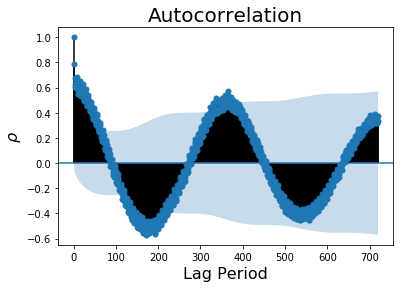

In [34]:
import statsmodels.api as sma
month = 12 * 2
lags = 30 * month
   
fig = plt.figure(figsize=(8, 6))
fig = sma.graphics.tsa.plot_acf(y.values.squeeze(), lags=lags)
plt.title(r'Autocorrelation', fontsize=20)
plt.xlabel('Lag Period', fontsize=16)
plt.ylabel(r'$\rho$', fontsize=16)

** AR (Moving Average) model shows obvious strong periodic autocorrelation of the average time series of daily Citi-Bike rides. It has high negative autocorrelation every 183 days (half year), and it high positive autocorrelation every 365 days (one year). And these autocorrelation degree does not decrease much as lag period increases. In conclusion, the average time series of daily Citi-Bike rides has strong and stable semi-annual periodic autocorrelation. **

# ARMA(1,1)

In [35]:
arma = sma.tsa.ARMA(y, order=(1,1)).fit()
print(arma.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1979
Model:                     ARMA(1, 1)   Log Likelihood               -1807.817
Method:                       css-mle   S.D. of innovations              0.603
Date:                Tue, 18 Dec 2018   AIC                           3623.633
Time:                        13:19:07   BIC                           3645.994
Sample:                    07-01-2013   HQIC                          3631.848
                         - 11-30-2018                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0045      0.104     -0.044      0.965        -0.209     0.200
ar.L1.y        0.9261      0.016     57.435      0.000         0.894     0.958
ma.L1.y       -0.4285      0.058     -7.326      0.0

** ARMA (Autoregressive moving average) model fits the time series of daily Citi-Bike rides extremely well. This ARMA model has a reliable confident interval, P-value and the AIR & BIC values show there is no overfitting problem. In conclusion, this time series has strong and stable autocorrelation and be well explained by the ARMA model. ARMA model is a key point for future study to predict the number of trips.**

# Detect trend and periodicity

1. $\lambda = 6.25$ for annual data.
2. $\lambda = 129600$ for monthly data.
3. $\lambda = 104976000000$ for daily data.

In [36]:
# Decompose into cyclical and trend components.
#cycle, trend = sma.tsa.filters.hpfilter(y, lamb = 6.25) # annual
cycle, trend = sma.tsa.filters.hpfilter(y, lamb = 129600) # monthly
#cycle, trend = sma.tsa.filters.hpfilter(y, lamb = 104976000000) # daily

Text(0,0.5,'$')

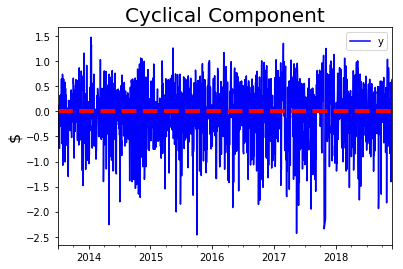

In [37]:
# Cyclical component
cycle.plot(color='blue')
plt.title('Cyclical Component', fontsize=20)
plt.axhline(0, color='r', ls='--', lw=4)
plt.ylabel('$', fontsize=16)

Text(0,0.5,'$')

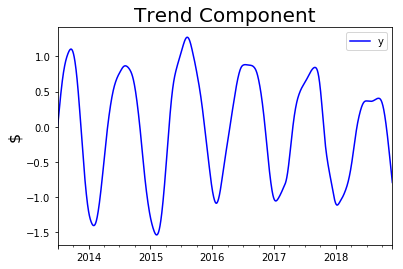

In [38]:
# Trend component.
trend.plot(color='blue')
plt.title('Trend Component', fontsize=20)
plt.ylabel('$', fontsize=16)

Text(0,0.5,'$\\rho$')

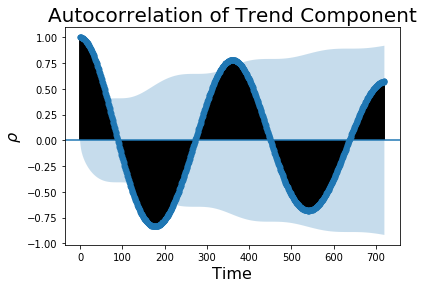

In [39]:
fig = plt.figure(figsize=(8, 6))
month = 12 * 2
lags = 30 * month
fig = sma.graphics.tsa.plot_acf(trend.squeeze(), lags=lags)
plt.title(r'Autocorrelation of Trend Component', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel(r'$\rho$', fontsize=16)

Text(0,0.5,'$\\rho$')

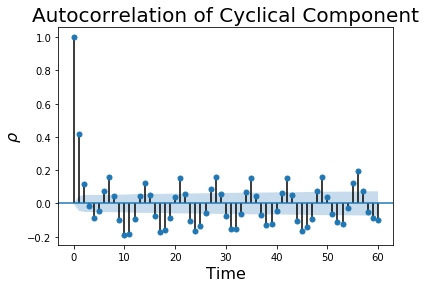

In [40]:
fig = plt.figure(figsize=(8, 6))
fig = sma.graphics.tsa.plot_acf(cycle.squeeze(), lags=60)
plt.title(r'Autocorrelation of Cyclical Component', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel(r'$\rho$', fontsize=16)

** After filtering the noise, the time series shows much stronger autocorrelation. And actually, the daily rides do not increase during the recent 5 years. What's more interesting? The noise component has a strong and stable periodic autocorrelation. And it is obvious that the period is 7 days, which means it is weekly periodic autocorrelation. In conclusion, weekdays and weekends are an important factor that influences the Citi-Bike rides. **

# Clustering

## kmeans clustering

In [41]:
def KM(nc, df):
    # KMeans caculation
    nc = nc
    km = KMeans(n_clusters=nc, random_state=1994).fit(df.fillna(value=0))    
    
    # kmlabel
    kmlabel = pd.DataFrame(km.labels_)
    
    # kmlabel_dictionary
    kmlabel_dictionary = {}
    for i in range(nc):
        kmlabel_dictionary[i] = list(kmlabel[kmlabel == i].dropna().index)
    return kmlabel, kmlabel_dictionary

In [42]:
def clusterplot(nc, kmlabel_dictionary, df):
    fig = plt.figure(figsize=(10,nc*2))
    for i in range(nc):
        for j in kmlabel_dictionary[i]:        
            ax = fig.add_subplot(nc/2+1 ,2,i+1)
            ax.plot(range(df.shape[1]), df.irow(j), 'black', alpha=0.1, linewidth=0.2)
        ax.plot(range(df.shape[1]), df.irow(kmlabel_dictionary[i]).mean(axis=0), 'r', alpha=1, linewidth=0.2)
        ax.set_ylabel('the number of start activities')
        ax.set_xticks([])
        ax.set_title('cluster%d'%(i))

def ShpMergeLabel(kmlabel, station, df):
    kmlabel_station = kmlabel.copy()
    kmlabel_station.index = df.index
    kmlabel_station.reset_index(inplace=True)
    kmlabel_station.columns=['id', 'km%d'%nc]
    kmlabel_station['id'] = kmlabel_station['id'].astype('int')
    shp = pd.merge(station, kmlabel_station, on='id', how='left')
    return shp

# cmap: https://matplotlib.org/tutorials/colors/colormaps.html
def spatialplot(shp):
    fig = plt.figure(figsize=(10,10))
    ax = ax = fig.add_subplot(111)
    shp.dropna().plot(column = 'km%d'%nc, cmap='viridis',edgecolor='black',legend=True,categorical=True, ax=ax)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: irow(i) is deprecated. Please use .iloc[i]
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


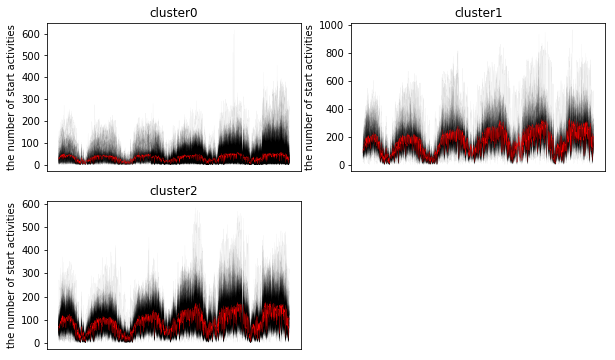

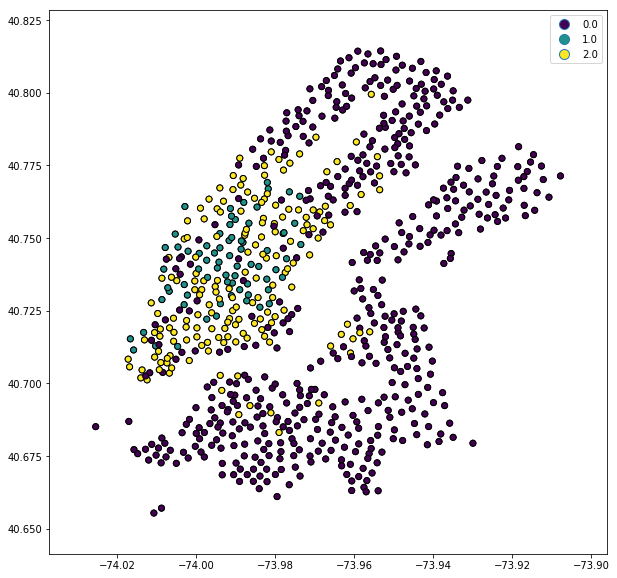

In [43]:
nc = 3
kmlabel, kmlabel_dictionary = KM(nc, df)
clusterplot(nc, kmlabel_dictionary, df)
shp = ShpMergeLabel(kmlabel, station, df)
spatialplot(shp)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: irow(i) is deprecated. Please use .iloc[i]
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


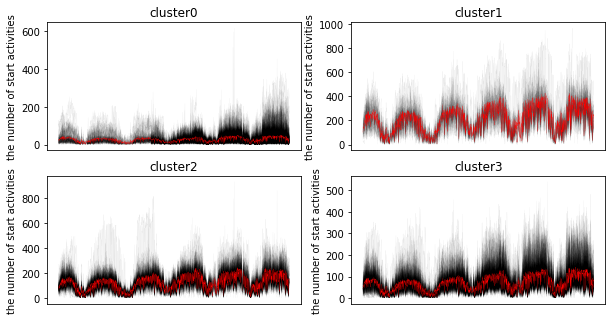

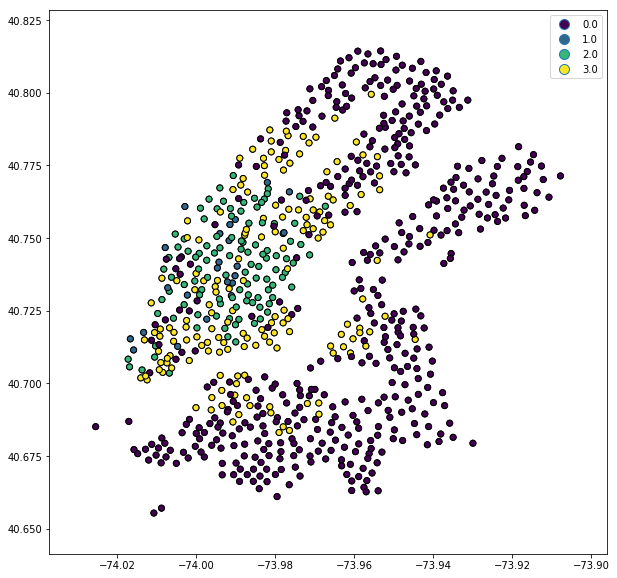

In [44]:
nc = 4
kmlabel, kmlabel_dictionary = KM(nc, df)
clusterplot(nc, kmlabel_dictionary, df)
shp = ShpMergeLabel(kmlabel, station, df)
spatialplot(shp)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: irow(i) is deprecated. Please use .iloc[i]
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


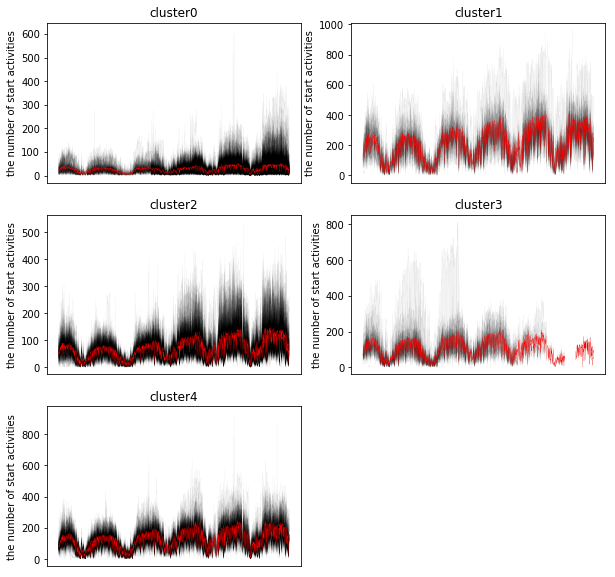

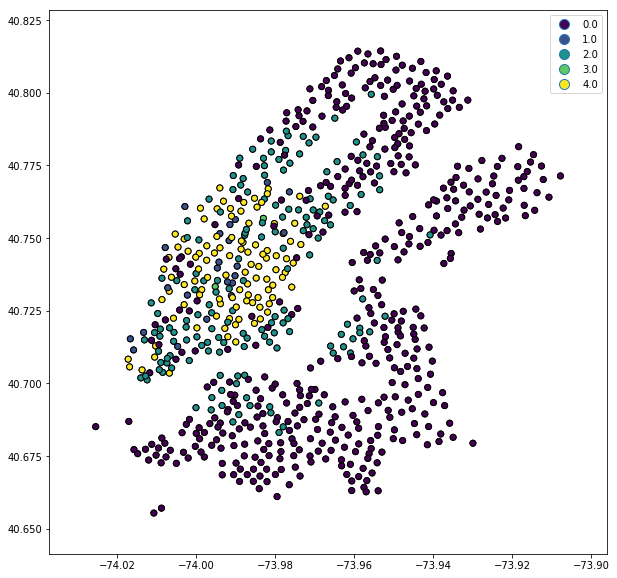

In [45]:
nc = 5
kmlabel, kmlabel_dictionary = KM(nc, df)
clusterplot(nc, kmlabel_dictionary, df)
shp = ShpMergeLabel(kmlabel, station, df)
spatialplot(shp)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: irow(i) is deprecated. Please use .iloc[i]
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


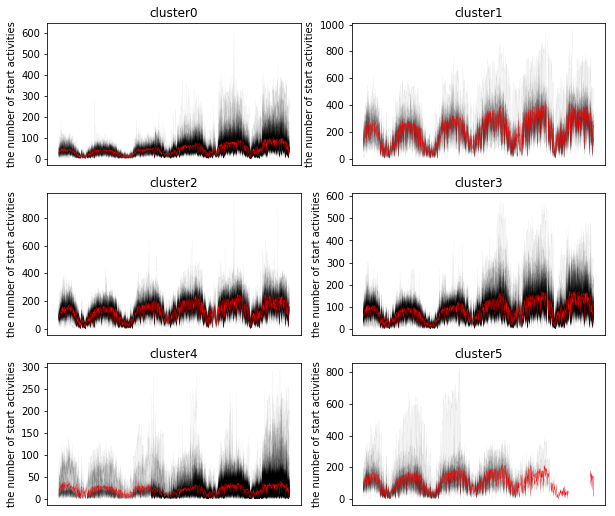

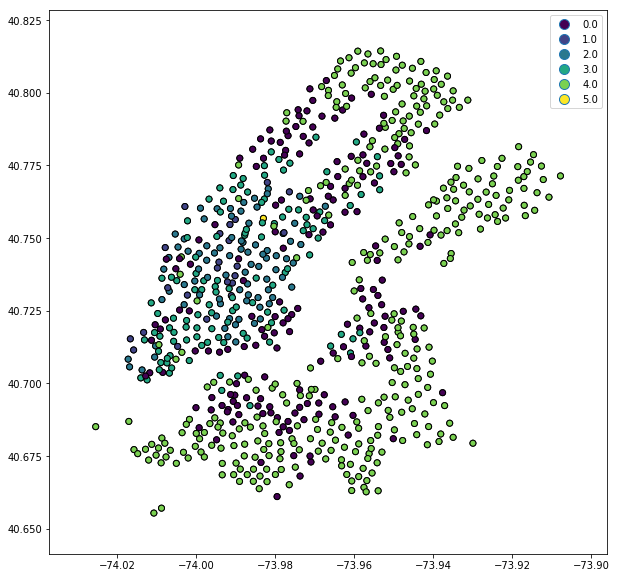

In [46]:
nc = 6
kmlabel, kmlabel_dictionary = KM(nc, df)
clusterplot(nc, kmlabel_dictionary, df)
shp = ShpMergeLabel(kmlabel, station, df)
spatialplot(shp)

** To observe the trend variation of time series in space, k-means clustering is carried out. The cluster number of 3, 4, 5, 6 are tried. The clustering shows an obvious pattern that the Midtown have unique and special time series trends, and downtown Brooklyn, the Lower Manhattan, the Upper East Side, and the Upper West Side share the similar time series trends. There shows a strong regional differentiation pattern of time series trend. **


** In conclusion, the average time series of daily Citi-Bike rides has strong and stable semi-annual periodic autocorrelation. And weekdays and weekends are an important factor that influences the Citi-Bike rides. In addition, there is a strong regional differentiation pattern of time series trend in New York. **

## Hierarchical agglomerative clustering (missing)

### Dendrogram of hierarchical clustering in scipy
It illustrates the arrangement of the clusters produced by the corresponding analyses.
refer to: https://en.wikipedia.org/wiki/Dendrogram

#### Runnable valid codes:

import scipy.cluster as scp
labels = list(df.index)
fig = pl.figure(figsize=(10,150), dpi=150)
pl.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(df.fillna(value=0), method='ward'),
                               labels = labels,
                               leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=8.,  # font size for the x axis labels)
                               orientation='left')
pl.yticks(rotation=0)

# Part II: Multi-factor study

### Weather data

https://www.meteoblue.com/en/weather/archive/export/new-york_united-states-of-america_5128581?daterange=2018-12-07+to+2018-12-14&params=&params%5B%5D=11%3B2+m+above+gnd&params%5B%5D=660%3Bsfc&params%5B%5D=32%3B10+m+above+gnd%3B31%3B10+m+above+gnd&utc_offset=-5&aggregation=hourly&temperatureunit=CELSIUS&windspeedunit=METER_PER_SECOND

!curl https://raw.githubusercontent.com/JunjieTsai/Datasets/master/weather_data_nyc_centralpark_2016.csv > weather2016.csv

weather2016 = pd.read_csv('weather2016.csv')
print(weather2016.shape)
weather2016#.head()

In [47]:
!curl https://raw.githubusercontent.com/JunjieTsai/Datasets/master/nycwhether.csv > nycweather.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4193k  100 4193k    0     0  15.7M      0 --:--:-- --:--:-- --:--:-- 15.8M


In [48]:
nycweather = pd.read_csv('nycweather.csv').drop('Unnamed: 0', axis=1)
nycweather = nycweather[nycweather[nycweather['Date']=='2013-07-01'].index[0] : ]
nycweather = nycweather[['Date', 'Mean.TemperatureF', 'MeanDew.PointF', 'Mean.Humidity', 'Mean.Sea.Level.PressureIn', 
                         'Mean.VisibilityMiles', 'Mean.Wind.SpeedMPH', 'PrecipitationIn']]
nycweather['PrecipitationIn'] = nycweather['PrecipitationIn'].replace('T', 0)
nycweather['PrecipitationIn'] = nycweather['PrecipitationIn'].astype(float)
nycweather = nycweather.fillna(value=0).drop(['Date'],axis=1)
nycweather.index = date_range[:len(nycweather)]
print(nycweather.shape)
nycweather.head()

(914, 7)


,Mean.TemperatureF,MeanDew.PointF,Mean.Humidity,Mean.Sea.Level.PressureIn,Mean.VisibilityMiles,Mean.Wind.SpeedMPH,PrecipitationIn
2013-07-01,75.0,70,91,29.99,5.0,11,0.98
2013-07-02,75.0,70,85,30.13,6.0,12,0.25
2013-07-03,76.0,70,86,30.23,10.0,10,0.09
2013-07-04,78.0,72,82,30.24,9.0,11,0.00
2013-07-05,80.0,72,79,30.18,10.0,10,0.00


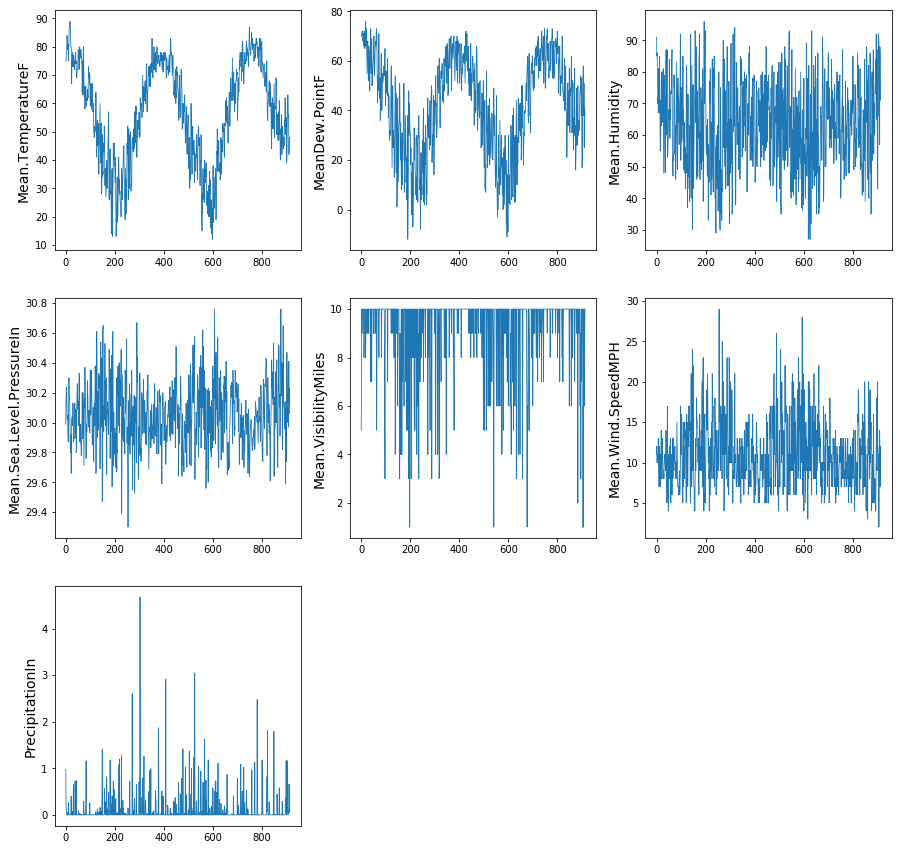

In [49]:
fig = plt.figure(figsize=(15,15))
for i in range(nycweather.shape[1]):
    ax = fig.add_subplot(3,3,i+1)
    ax.plot(range(nycweather.shape[0]), nycweather[nycweather.columns[i]], '-', linewidth=0.8)
    ax.set_ylabel(nycweather.columns[i], fontsize=14)

###  Holiday 
**Whether the day is holiday**

In [50]:
# Generate a list of holidays over this period
from pandas.tseries.holiday import USFederalHolidayCalendar
calendar = USFederalHolidayCalendar()
holidays_all = calendar.holidays(date_range[0], date_range[len(date_range)-1])
holidays_all

DatetimeIndex(['2013-07-04', '2013-09-02', '2013-10-14', '2013-11-11',
               '2013-11-28', '2013-12-25', '2014-01-01', '2014-01-20',
               '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01',
               '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25',
               '2015-01-01', '2015-01-19', '2015-02-16', '2015-05-25',
               '2015-07-03', '2015-09-07', '2015-10-12', '2015-11-11',
               '2015-11-26', '2015-12-25', '2016-01-01', '2016-01-18',
               '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05',
               '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-26',
               '2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29',
               '2017-07-04', '2017-09-04', '2017-10-09', '2017-11-10',
               '2017-11-23', '2017-12-25', '2018-01-01', '2018-01-15',
               '2018-02-19', '2018-05-28', '2018-07-04', '2018-09-03',
               '2018-10-08', '2018-11-12', '2018-11-22'],
              dtype

In [51]:
print(date_range[2])
calendar.holidays(date_range[1], date_range[2])

2013-07-03 00:00:00


DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [52]:
holidays = []
for i in range(len(date_range)):
    holidays.append(len(calendar.holidays(date_range[i-1], date_range[i])))

In [53]:
holidays = pd.DataFrame(holidays)
holidays.index = date_range
holidays.columns = ['holidays']
print(holidays.shape)
holidays.head()

(1979, 1)


,holidays
2013-07-01,0
2013-07-02,0
2013-07-03,0
2013-07-04,1
2013-07-05,1


### Weekdays 
**Whether the day is weekday**<br>
refer to https://cloud.tencent.com/developer/ask/176278

In [54]:
holiday_date_list = holidays_all.date.tolist()

In [55]:
np.busday_count(date_range[0].date(), date_range[len(date_range)-1].date(), holidays = holiday_date_list)

1359

In [56]:
np.busday_count(date_range[0].date(), date_range[12].date(), holidays = holiday_date_list)

9

In [57]:
weekdays = []
for i in range(len(date_range)):
    weekdays.append(np.busday_count(date_range[i-1].date(), date_range[i].date(), holidays = holiday_date_list))
weekdays[0] = weekdays[12]

In [58]:
weekdays = pd.DataFrame(weekdays)
weekdays.index = date_range
weekdays.columns = ['weekdays']
print(weekdays.shape)
weekdays.head()

(1979, 1)


,weekdays
2013-07-01,1
2013-07-02,1
2013-07-03,1
2013-07-04,1
2013-07-05,0


### Events data (Missing)
**number & magnitude of events in the date**

### Merge

In [59]:
multivar = nycweather.copy()[['Mean.TemperatureF', 'Mean.Humidity', 'Mean.Wind.SpeedMPH', 'PrecipitationIn']]
#multivar = pd.merge(y, multivar, left_index=True, right_index=True, how='right')
multivar = pd.merge(multivar, holidays, left_index=True, right_index=True, how='left')
multivar = pd.merge(multivar, weekdays, left_index=True, right_index=True, how='left')
multivar.columns = ['TemperatureF', 'Humidity',
       'WindSpeedMPH', 'PrecipitationIn', 'holidays', 'weekdays']
print(multivar.shape)
multivar.head()

(914, 6)


,TemperatureF,Humidity,WindSpeedMPH,PrecipitationIn,holidays,weekdays
2013-07-01,75.0,91,11,0.98,0,1
2013-07-02,75.0,85,12,0.25,0,1
2013-07-03,76.0,86,10,0.09,0,1
2013-07-04,78.0,82,11,0.00,1,1
2013-07-05,80.0,79,10,0.00,1,0


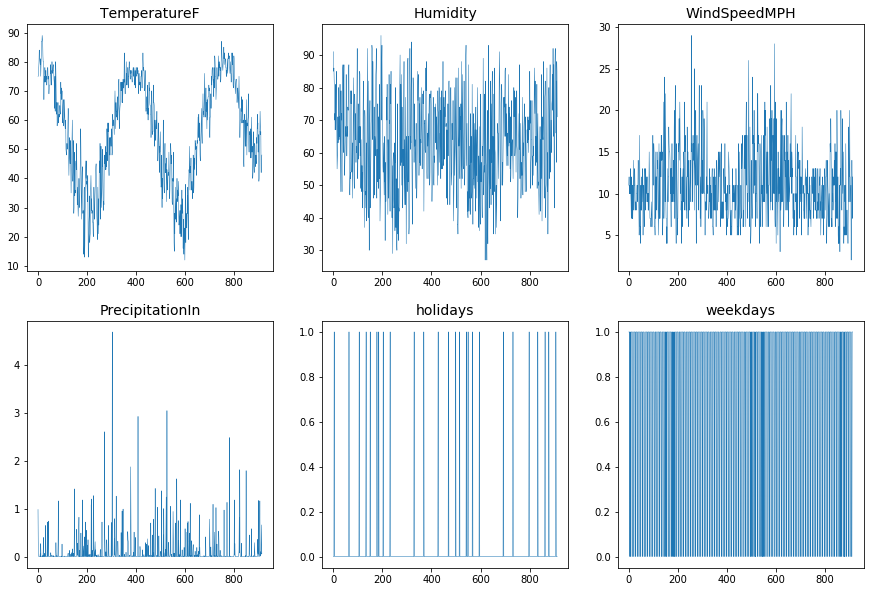

In [60]:
fig = plt.figure(figsize=(15,10))
for i in range(multivar.shape[1]):
    ax = fig.add_subplot(2,3,i+1)
    ax.plot(range(multivar.shape[0]), multivar[multivar.columns[i]], '-', linewidth=0.5)
    ax.set_title(multivar.columns[i], fontsize=14)

### Average citi bike start activity dataframe

x = range(df.shape[1]), 
x = pd.DataFrame(list(x[0]))
x.index = y.index

df_mean = pd.merge(x, y, left_index=True, right_index=True)
df_mean.columns = ['x', 'y']
df_mean.head()

In [61]:
y = y_all[:len(multivar)]
y.columns = ['start_station_activities']
print(y.shape)
y.head()

(914, 1)


,start_station_activities
2013-07-01,52.482540
2013-07-02,71.752381
2013-07-03,68.914286
2013-07-04,70.352381
2013-07-05,68.812698


In [62]:
# this data is for later PCA use
y_valid = y
multivar_valid = multivar

## Standardize

In [63]:
y = standardize(y)
y.describe()

,start_station_activities
count,9.140000e+02
mean,3.265076e-16
std,1.000547e+00
min,-2.235840e+00
25%,-8.284463e-01
50%,1.831037e-01
75%,8.376393e-01
max,1.803934e+00


In [64]:
multivar = standardize(multivar)
multivar.describe()

,TemperatureF,Humidity,WindSpeedMPH,PrecipitationIn,holidays,weekdays
count,9.140000e+02,9.140000e+02,9.140000e+02,9.140000e+02,9.140000e+02,9.140000e+02
mean,-1.554798e-17,-1.671408e-16,-1.788018e-16,-2.001803e-16,-4.081345e-17,1.435759e-16
std,1.000547e+00,1.000547e+00,1.000547e+00,1.000547e+00,1.000547e+00,1.000547e+00
min,-2.502658e+00,-2.656896e+00,-2.202772e+00,-3.244681e-01,-2.456111e-01,-1.481825e+00
25%,-7.581611e-01,-7.436669e-01,-7.367524e-01,-3.244681e-01,-2.456111e-01,-1.481825e+00
50%,1.422245e-01,-7.809428e-03,-2.480792e-01,-3.244681e-01,-2.456111e-01,6.748437e-01
75%,8.737877e-01,7.280480e-01,4.849306e-01,-2.381657e-01,-2.456111e-01,6.748437e-01
max,1.830447e+00,2.420520e+00,4.394316e+00,1.313871e+01,4.071477e+00,6.748437e-01


# Train & Test split
**Train dataset: 2 years, from 07/ 01/ 2013 to 06/ 01/ 2015 **<br>
**Test dataset: half year, from 07/ 01/ 2015 to 12/ 01/ 2015 **

In [65]:
y_test = y[365*2:]
y = y[:365*2]
print(y_test.shape)
print(y.shape)

(184, 1)
(730, 1)


In [66]:
multivar_test = multivar[365*2:]
multivar = multivar[:365*2]
print(multivar_test.shape)
print(multivar.shape)

(184, 6)
(730, 6)


## Colinearity study between specific factor and the number of the citibike start activities

In [67]:
test = multivar_test.merge(y_test, left_index=True, right_index=True)

In [68]:
multivar_y = multivar.merge(y, left_index=True, right_index=True)
modlist = []

### Temperature

In [69]:
temp = multivar_y.sort_values(by=[multivar_y.columns[0]])
mod = sm.OLS(temp['start_station_activities'], sm.add_constant(temp.TemperatureF)).fit()
modlist.append(mod)
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     start_station_activities   R-squared:                       0.645
Model:                                  OLS   Adj. R-squared:                  0.644
Method:                       Least Squares   F-statistic:                     1322.
Date:                      Tue, 18 Dec 2018   Prob (F-statistic):          7.84e-166
Time:                              13:19:35   Log-Likelihood:                -656.87
No. Observations:                       730   AIC:                             1318.
Df Residuals:                           728   BIC:                             1327.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const           -0.0212      0.022     -0.953      0.341        -0.065     0.022
TemperatureF     0.7867      0.022     36.361      0.000         0.744     0.829
==============================================================================
Omnibus:                       20.802   Durbin-Watson:                   1.666
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.824
Skew:                          -0.409   Prob(JB):                     1.82e-05
Kurtosis:                       2.784   Cond. No.                         1.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Humidity

In [70]:
temp = multivar_y.sort_values(by=[multivar_y.columns[1]])
mod = sm.OLS(temp['start_station_activities'], sm.add_constant(temp.Humidity)).fit()
modlist.append(mod)
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     start_station_activities   R-squared:                       0.002
Model:                                  OLS   Adj. R-squared:                  0.000
Method:                       Least Squares   F-statistic:                     1.189
Date:                      Tue, 18 Dec 2018   Prob (F-statistic):              0.276
Time:                              13:19:35   Log-Likelihood:                -1034.2
No. Observations:                       730   AIC:                             2072.
Df Residuals:                           728   BIC:                             2082.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.1194      0.037     -3.229      0.001        -0.192    -0.047
Humidity       0.0396      0.036      1.090      0.276        -0.032     0.111
==============================================================================
Omnibus:                      285.541   Durbin-Watson:                   1.759
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.886
Skew:                          -0.294   Prob(JB):                     4.00e-11
Kurtosis:                       1.891   Cond. No.                         1.03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Wind Speed (MPH)

In [71]:
temp = multivar_y.sort_values(by=[multivar_y.columns[2]])
mod = sm.OLS(temp['start_station_activities'], sm.add_constant(temp.WindSpeedMPH)).fit()
modlist.append(mod)
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     start_station_activities   R-squared:                       0.102
Model:                                  OLS   Adj. R-squared:                  0.101
Method:                       Least Squares   F-statistic:                     83.12
Date:                      Tue, 18 Dec 2018   Prob (F-statistic):           7.41e-19
Time:                              13:19:35   Log-Likelihood:                -995.31
No. Observations:                       730   AIC:                             1995.
Df Residuals:                           728   BIC:                             2004.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const           -0.0997      0.035     -2.839      0.005        -0.169    -0.031
WindSpeedMPH    -0.3123      0.034     -9.117      0.000        -0.380    -0.245
==============================================================================
Omnibus:                       98.603   Durbin-Watson:                   1.540
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.598
Skew:                          -0.339   Prob(JB):                     6.85e-09
Kurtosis:                       2.119   Cond. No.                         1.07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### PrecipitationIn

In [72]:
temp = multivar_y.sort_values(by=[multivar_y.columns[3]])
mod = sm.OLS(temp['start_station_activities'], sm.add_constant(temp.PrecipitationIn)).fit()
modlist.append(mod)
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     start_station_activities   R-squared:                       0.087
Model:                                  OLS   Adj. R-squared:                  0.086
Method:                       Least Squares   F-statistic:                     69.38
Date:                      Tue, 18 Dec 2018   Prob (F-statistic):           4.02e-16
Time:                              13:19:35   Log-Likelihood:                -1001.5
No. Observations:                       730   AIC:                             2007.
Df Residuals:                           728   BIC:                             2016.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const              -0.1180      0.035     -3.336      0.001        -0.187    -0.049
PrecipitationIn    -0.2907      0.035     -8.329      0.000        -0.359    -0.222
==============================================================================
Omnibus:                      192.768   Durbin-Watson:                   0.843
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.817
Skew:                          -0.274   Prob(JB):                     8.31e-10
Kurtosis:                       1.963   Cond. No.                         1.02
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Holidays

In [73]:
temp = multivar_y.sort_values(by=[multivar_y.columns[4]])
mod = sm.OLS(temp['start_station_activities'], sm.add_constant(temp.holidays)).fit()
modlist.append(mod)
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     start_station_activities   R-squared:                       0.015
Model:                                  OLS   Adj. R-squared:                  0.013
Method:                       Least Squares   F-statistic:                     10.73
Date:                      Tue, 18 Dec 2018   Prob (F-statistic):            0.00110
Time:                              13:19:35   Log-Likelihood:                -1029.4
No. Observations:                       730   AIC:                             2063.
Df Residuals:                           728   BIC:                             2072.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.1214      0.037     -3.305      0.001        -0.194    -0.049
holidays      -0.1225      0.037     -3.276      0.001        -0.196    -0.049
==============================================================================
Omnibus:                      300.370   Durbin-Watson:                   0.593
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.877
Skew:                          -0.285   Prob(JB):                     4.01e-11
Kurtosis:                       1.882   Cond. No.                         1.02
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Weekdays

In [74]:
temp = multivar_y.sort_values(by=[multivar_y.columns[5]])
mod = sm.OLS(temp['start_station_activities'], sm.add_constant(temp.weekdays)).fit()
modlist.append(mod)
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     start_station_activities   R-squared:                       0.010
Model:                                  OLS   Adj. R-squared:                  0.009
Method:                       Least Squares   F-statistic:                     7.395
Date:                      Tue, 18 Dec 2018   Prob (F-statistic):            0.00670
Time:                              13:19:35   Log-Likelihood:                -1031.1
No. Observations:                       730   AIC:                             2066.
Df Residuals:                           728   BIC:                             2075.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.1204      0.037     -3.271      0.001        -0.193    -0.048
weekdays       0.1002      0.037      2.719      0.007         0.028     0.173
==============================================================================
Omnibus:                      324.901   Durbin-Watson:                   0.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.382
Skew:                          -0.321   Prob(JB):                     6.96e-12
Kurtosis:                       1.870   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Colinearity plot

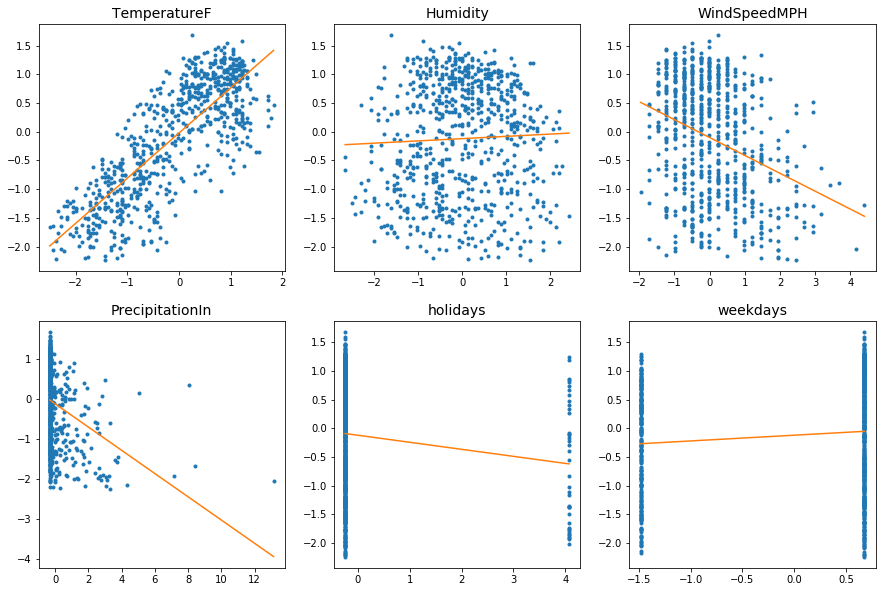

In [75]:
fig = plt.figure(figsize=(15,10))
for i in range(multivar.shape[1]):
    ax = fig.add_subplot(2,3,i+1)
    temp = multivar_y.sort_values(by=[multivar_y.columns[i]])
    ax.plot(temp[temp.columns[i]], temp['start_station_activities'], '.')
    ax.plot(temp[temp.columns[i]], modlist[i].fittedvalues, '-')
    ax.set_title(multivar.columns[i], fontsize=14)

** Collinearity models are built to explore the correlation between the time series of Citi-Bike rides 6 chosen features. Temperature has an extremely strong correlation with the Citi-Bike rides in time series, and the R-squared is high as 0.645. Wind speed and precipitation have a slight correlation with the Citi-Bike rides in time series with the R-squared around 0.1. At the same time, other features humidity, holiday, and weekday do not have the obvious and direct correlation with the Citi-Bike rides in time series. **

** In conclusion, unlike the original hypothesis, the factors most affect the periodic variation of the Citi-Bike rides are temperature, wind speed, and precipitation.  **

****

## Multivariate linear regression model

### All related factors: Temperature & Wind Speed & Humidity & Precipitation & holidays & weekdays

In [76]:
def modelEval(VarSlice, lm, key = 'start_station_activities'):
    lmy = lm.predict(test[VarSlice])
    y_err = lmy - test[key]
    y_norm = test[key]-np.mean(test[key])
    return 1-y_err.dot(y_err)/y_norm.dot(y_norm)  # R2 w.r.t. test set

In [77]:
multimod6 = sm.OLS(y, multivar).fit()
multimod6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     start_station_activities   R-squared:                       0.771
Model:                                  OLS   Adj. R-squared:                  0.769
Method:                       Least Squares   F-statistic:                     406.0
Date:                      Tue, 18 Dec 2018   Prob (F-statistic):          8.79e-228
Time:                              13:19:36   Log-Likelihood:                -502.22
No. Observations:                       730   AIC:                             1016.
Df Residuals:                           724   BIC:                             1044.
Df Model:                                 6                                         
Covariance Type:                  nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
TemperatureF        0.8192      0.019     42.400      0.000         0.781     0.857
Humidity           -0.1905      0.021     -9.055      0.000        -0.232    -0.149
WindSpeedMPH       -0.0878      0.019     -4.639      0.000        -0.125    -0.051
PrecipitationIn    -0.1963      0.020     -9.949      0.000        -0.235    -0.158
holidays           -0.0672      0.019     -3.571      0.000        -0.104    -0.030
weekdays            0.0995      0.018      5.389      0.000         0.063     0.136
==============================================================================
Omnibus:                        1.791   Durbin-Watson:                   0.901
Prob(Omnibus):                  0.408   Jarque-Bera (JB):                1.628
Skew:                          -0.102   Prob(JB):                        0.443
Kurtosis:                       3.108   Cond. No.                         1.91
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
print('In sample R-squared: %f'%multimod6.rsquared)
print('Out of sample R-squared: %f'%modelEval(list(range(6)), multimod6))

In sample R-squared: 0.770870
Out of sample R-squared: 0.694391


### 3 most related factors: Temperature & Wind Speed & Precipitation

In [79]:
multimod3 = sm.OLS(y, multivar[[0,2,3]]).fit()
multimod3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     start_station_activities   R-squared:                       0.728
Model:                                  OLS   Adj. R-squared:                  0.726
Method:                       Least Squares   F-statistic:                     647.3
Date:                      Tue, 18 Dec 2018   Prob (F-statistic):          9.10e-205
Time:                              13:19:36   Log-Likelihood:                -565.35
No. Observations:                       730   AIC:                             1137.
Df Residuals:                           727   BIC:                             1150.
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
TemperatureF        0.7664      0.020     38.425      0.000         0.727     0.806
WindSpeedMPH       -0.0529      0.020     -2.636      0.009        -0.092    -0.014
PrecipitationIn    -0.2677      0.019    -13.864      0.000        -0.306    -0.230
==============================================================================
Omnibus:                        5.356   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.069   Jarque-Bera (JB):                5.192
Skew:                          -0.194   Prob(JB):                       0.0746
Kurtosis:                       3.143   Cond. No.                         1.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
print('In sample R-squared: %f'%multimod3.rsquared)
print('Out of sample R-squared: %f'%modelEval([0,2,3], multimod3))

In sample R-squared: 0.727606
Out of sample R-squared: 0.582716


** To predict the number of daily Citi-Bike rides, 2 multivariate linear regression models are built. One complex model has the variables of all above 6 features,  temperature, wind, rainfall, snowfall, holiday and weekday. Another restricted model has the 3 most important variables, temperature, wind speed, and precipitation. The complex model with 6 features has in sample R-squared: 0.77 and out of sample R-squared: 0.69. The restricted model with 3 features has in sample R-squared: 0.73 and Out of sample R-squared: 0.58. The complex model with 6 features has good fit and prediction almost without overfitting problem. The restricted model with 3 features has a good fit but much worse prediction which means there may be an overfitting problem. **

### LR test

** Significance level:  α=0.05α=0.05 **

** Null hypothesis: the restricted model (of 3 features) is better than the complex model (of 6 features). **

** The difference in the number of degrees of freedom is 3.**

In [81]:
def LRtest(RestrictedMod, ComplexMod, DOF, alpha = 0.05):
    LR = ComplexMod.compare_lr_test(RestrictedMod)
    print ("LR : ", -2 * (RestrictedMod.llf - (ComplexMod.llf)))
    print ("LR from statsmodels:", LR)
    
    if DOF == 1:
        level = 3.84 #0.05 level for 1 DOF chi sq distribution 
    if DOF == 2:
        level = 5.99 #0.05 level for 2 DOF chi sq distribution 
    if DOF == 3:
        level = 7.81 #0.05 level for 3 DOF chi sq distribution 
        
    if LR[0] < level: 
        print ("CANNOT reject the Null hypothesis that the restricted model is better than" +
               "the complex model with p-value") 
        print ("p > %.3f"%alpha)
    else:
        print ("We reject the Null hypothesis that the restricted " + 
               "model is better than the complex model with p-value ")
        print ("p < %.3f"%alpha)    
    
    return LR

In [82]:
LR = LRtest(RestrictedMod=multimod3, ComplexMod=multimod6,DOF=3, alpha = 0.05)

LR :  126.263372273
LR from statsmodels: (126.26337227301292, 3.4533091869618185e-27, 3.0)
We reject the Null hypothesis that the restricted model is better than the complex model with p-value 
p < 0.050


** LR test is carried out to compare these 2 models. The significance level is set at 0.05. And the null hypothesis is that the restricted model (of 3 features) is better than the complex model (of 6 features). The difference in the number of degrees of freedom is 3. the LR value is 126.26, much bigger than 7.81, the 0.05 level for 3 DOF chi-square distribution. And the P-value is infinite. In conclusion, the complex model (of 6 features) is the better model. 
In conclusion, the complex model with variables of all 6 features,  temperature, wind, rainfall, snowfall, holiday and weekday is a good model to fit and predict the number of the daily Citi-Bike rides. This model can fit and predict 70% of the data. **

## Correlation matrix

** Analyze the mutual influence among the variables **

In [83]:
multivar.corr()

,TemperatureF,Humidity,WindSpeedMPH,PrecipitationIn,holidays,weekdays
TemperatureF,1.000000,0.339965,-0.306475,-0.022996,-0.053271,-0.011570
Humidity,0.339965,1.000000,-0.249789,0.377889,-0.022349,0.018019
WindSpeedMPH,-0.306475,-0.249789,1.000000,0.100281,0.013798,-0.023310
PrecipitationIn,-0.022996,0.377889,0.100281,1.000000,-0.055766,0.020762
holidays,-0.053271,-0.022349,0.013798,-0.055766,1.000000,-0.240371
weekdays,-0.011570,0.018019,-0.023310,0.020762,-0.240371,1.000000


## Scatter matrix of all variables

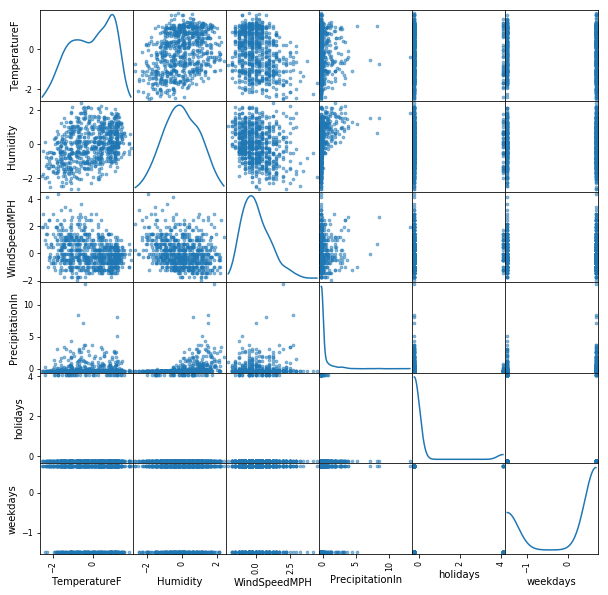

In [84]:
sfig = pd.scatter_matrix(multivar, s=30, figsize=(10, 10), diagonal='kde')

***

## Multivariate linear regression model (PCA)

In [85]:
# this data is for later PCA use
y = y_valid
multivar = multivar_valid

## Standardize

In [86]:
y = standardize(y)
y.describe()

,start_station_activities
count,9.140000e+02
mean,3.265076e-16
std,1.000547e+00
min,-2.235840e+00
25%,-8.284463e-01
50%,1.831037e-01
75%,8.376393e-01
max,1.803934e+00


In [87]:
multivar = standardize(multivar)
multivar.describe()

,TemperatureF,Humidity,WindSpeedMPH,PrecipitationIn,holidays,weekdays
count,9.140000e+02,9.140000e+02,9.140000e+02,9.140000e+02,9.140000e+02,9.140000e+02
mean,-1.554798e-17,-1.671408e-16,-1.788018e-16,-2.001803e-16,-4.081345e-17,1.435759e-16
std,1.000547e+00,1.000547e+00,1.000547e+00,1.000547e+00,1.000547e+00,1.000547e+00
min,-2.502658e+00,-2.656896e+00,-2.202772e+00,-3.244681e-01,-2.456111e-01,-1.481825e+00
25%,-7.581611e-01,-7.436669e-01,-7.367524e-01,-3.244681e-01,-2.456111e-01,-1.481825e+00
50%,1.422245e-01,-7.809428e-03,-2.480792e-01,-3.244681e-01,-2.456111e-01,6.748437e-01
75%,8.737877e-01,7.280480e-01,4.849306e-01,-2.381657e-01,-2.456111e-01,6.748437e-01
max,1.830447e+00,2.420520e+00,4.394316e+00,1.313871e+01,4.071477e+00,6.748437e-01


## PCA

In [88]:
from sklearn.decomposition import PCA

[ 0.26695689  0.21375812  0.19785503  0.13077071  0.11176529  0.07889395]
we need 6 PCs to explain 600.00 percent of variance


Text(0,0.5,'variance')

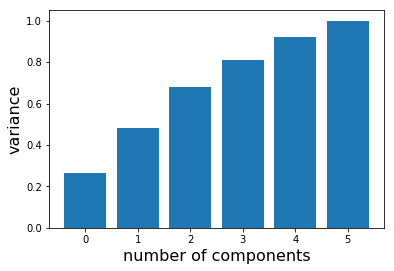

In [89]:
n=6 # how many eigenvectors we choose
pca = PCA(n,whiten=True) #PCA model, paramerized by the target number of components or target percentage of variance
pca.fit(multivar) #fit the model to the data
P=pca.transform(multivar)
eigenvalues = pca.explained_variance_
print(pca.explained_variance_ratio_)
print("we need %d PCs to explain %.2f percent of variance"%(P.shape[1],100*n))
plt.bar(np.arange(n), eigenvalues.cumsum()/sum(eigenvalues))
plt.xlabel('number of components', fontsize=16)
plt.ylabel('variance', fontsize=16)

### Train & Test split
**Train dataset: 2 years, from 07/ 01/ 2013 to 06/ 01/ 2015 **<br>
**Test dataset: half year, from 07/ 01/ 2015 to 12/ 01/ 2015 **

In [90]:
y_test = y[365*2:]
y = y[:365*2]
print(y_test.shape)
print(y.shape)

(184, 1)
(730, 1)


In [91]:
multivar_test = P[365*2:]
multivar = P[:365*2]
print(multivar_test.shape)
print(multivar.shape)

(184, 6)
(730, 6)


test = multivar_test.merge(y_test, left_index=True, right_index=True)
multivar_y = multivar.merge(y, left_index=True, right_index=True)

### Multivariate OLS modeling

### With all features

In [92]:
multimod = sm.OLS(y, multivar[:,0:6]).fit()
multimod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     start_station_activities   R-squared:                       0.771
Model:                                  OLS   Adj. R-squared:                  0.769
Method:                       Least Squares   F-statistic:                     406.0
Date:                      Tue, 18 Dec 2018   Prob (F-statistic):          8.79e-228
Time:                              13:19:39   Log-Likelihood:                -502.22
No. Observations:                       730   AIC:                             1016.
Df Residuals:                           724   BIC:                             1044.
Df Model:                                 6                                         
Covariance Type:                  nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.3995      0.017    -23.148      0.000        -0.433    -0.366
x2            -0.3657      0.018    -20.322      0.000        -0.401    -0.330
x3             0.4588      0.018     25.770      0.000         0.424     0.494
x4             0.1721      0.018      9.504      0.000         0.137     0.208
x5            -0.4359      0.018    -24.804      0.000        -0.470    -0.401
x6             0.1763      0.018      9.867      0.000         0.141     0.211
==============================================================================
Omnibus:                        1.791   Durbin-Watson:                   0.901
Prob(Omnibus):                  0.408   Jarque-Bera (JB):                1.628
Skew:                          -0.102   Prob(JB):                        0.443
Kurtosis:                       3.108   Cond. No.                         1.08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
# calculate the Out of sample R-squared
lmy = multimod.predict(multivar_test[:,0:6])

# convert the y_test to 1D numpy array
temp =  np.zeros(len(lmy))
for i in range(184):
    temp[i] = y_test.values[i][0]
y_test = temp

y_err = lmy - y_test
y_norm = y_test-np.mean(y_test)
OutofSampleRsquared = 1-y_err.dot(y_err)/y_norm.dot(y_norm)  # R2 w.r.t. test set

print('In sample R-squared: %f'%multimod.rsquared)
print('Out of sample R-squared: %f'%OutofSampleRsquared)

In sample R-squared: 0.770870
Out of sample R-squared: 0.694391


### With 3 most related features

In [94]:
multimod = sm.OLS(y, multivar[:,0:3]).fit()
multimod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     start_station_activities   R-squared:                       0.519
Model:                                  OLS   Adj. R-squared:                  0.517
Method:                       Least Squares   F-statistic:                     261.8
Date:                      Tue, 18 Dec 2018   Prob (F-statistic):          3.63e-115
Time:                              13:19:39   Log-Likelihood:                -772.68
No. Observations:                       730   AIC:                             1551.
Df Residuals:                           727   BIC:                             1565.
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.3998      0.025    -16.033      0.000        -0.449    -0.351
x2            -0.3725      0.026    -14.319      0.000        -0.424    -0.321
x3             0.4482      0.026     17.431      0.000         0.398     0.499
==============================================================================
Omnibus:                        0.398   Durbin-Watson:                   0.941
Prob(Omnibus):                  0.819   Jarque-Bera (JB):                0.463
Skew:                          -0.052   Prob(JB):                        0.793
Kurtosis:                       2.934   Cond. No.                         1.05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [95]:
# calculate the Out of sample R-squared
lmy = multimod.predict(multivar_test[:,0:3])

y_err = lmy - y_test
y_norm = y_test-np.mean(y_test)
OutofSampleRsquared = 1-y_err.dot(y_err)/y_norm.dot(y_norm)  # R2 w.r.t. test set

print('In sample R-squared: %f'%multimod.rsquared)
print('Out of sample R-squared: %f'%OutofSampleRsquared)

In sample R-squared: 0.519276
Out of sample R-squared: 0.346154


** By correlation analysis, there shows slight mutual correlation among the 6 features. Thus PCA transformation is tried to reduce the correlation among the features. Actually, the PCA main component analysis shows that these 6 features are all independent enough to be the main components. And after the PCA transformation, the performance of the model does not improve a lot. In a word, in this case, there is no need to do PCA transformation. **

** In conclusion, firstly the time series of daily Citi-Bike rides has strong and stable semi-annual periodic autocorrelation. And there is a strong regional differentiation pattern of time series trend in New York. Secondly, the factors most affect the periodic variation of the Citi-Bike rides are temperature, wind speed, and precipitation. Thirdly, the multivariate linear regression model with variables of 6 features (temperature, wind, rainfall, snowfall, holiday and weekday) is a good model to fit and predict the number of the daily Citi-Bike rides. This model can fit and predict 70% of the data.**

# Overall conclusion

** In conclusion, firstly the time series of daily Citi-Bike rides has strong and stable semi-annual periodic autocorrelation. And there is a strong regional differentiation pattern of time series trend in New York. Secondly, the factors most affect the periodic variation of the Citi-Bike rides are temperature, wind speed, and precipitation. Thirdly, the multivariate linear regression model with variables of 6 features (temperature, wind, rainfall, snowfall, holiday and weekday) is a good model to fit and predict the number of the daily Citi-Bike rides. This model can fit and predict 70% of the data.**

# Future work: 


** First, the ARMA model performs well and will be deepened and optimized for further study. In addition, more machine learning models, such as random forest regression model will be used to predict the daily Citi-Bike rides. Secondly, more factors, such as event will be included in for more precise prediction. Finally, fill the value of missing days with the average algorithm instead of zero to reduce their disturbance.**

****